# Basic depth map processing

In [1]:
import cv2
from pathlib import Path
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
from torchvision.models import ResNet18_Weights
import torch
from sklearn.model_selection import StratifiedKFold
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
import numpy as np
from sklearn.model_selection import train_test_split


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Visualization

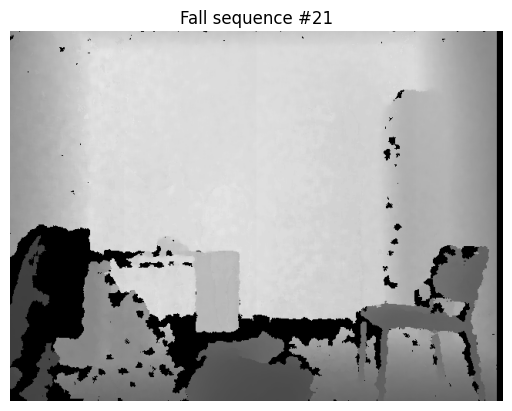

In [2]:
label = 'fall' # fall, adl
sequence_number = random.randint(0, 40 if label == 'adl' else 30) + 1
selected_video = Path(f'../datasets/{label}/sequence-{sequence_number:02}')

frames = sorted(selected_video.glob('*.png'))

for frame_path in frames:
    frame = cv2.imread(str(frame_path))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    plt.imshow(frame)
    plt.title(f'{label.capitalize()} sequence #{sequence_number}')
    plt.axis('off')
    plt.show()

# Dataset

In [3]:
root = Path('../datasets')
out_root = Path('../data_basic_depth')

if not out_root.exists():
    out_root.mkdir(exist_ok=True)
    for cls in ['adl', 'fall']:
        for seq in (root / cls).iterdir():
            if not seq.is_dir():
                continue

            out_seq = out_root / cls / seq.name
            out_seq.mkdir(parents=True, exist_ok=True)

            for f in sorted(seq.glob('*.png')):
                img = Image.open(f).convert('RGB')
                img = img.resize((128, 128), Image.BILINEAR)
                arr = np.array(img, dtype=np.uint8)  # (H, W, 3)

                np.save(out_seq / f'{f.stem}.npy', arr)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, number_of_frames=180):
        self.samples = []
        self.transform = transform
        self.number_of_frames = number_of_frames

        classes = ['adl', 'fall']
        for label_idx, cls in enumerate(classes):
            cls_path = Path(root_dir) / cls
            for seq_folder in cls_path.iterdir():
                if seq_folder.is_dir():
                    frames = sorted(seq_folder.glob('*.npy'))
                    if len(frames) > 0:
                        self.samples.append((frames, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        T = len(frame_paths)

        if T >= self.number_of_frames:
            frame_paths = frame_paths[-self.number_of_frames:]
        else:
            pad = self.number_of_frames - T
            frame_paths = [frame_paths[0]] * pad + frame_paths

        imgs = []
        for f in frame_paths:
            arr = np.load(f)              # (H, W, 3), uint8
            img = Image.fromarray(arr)

            if self.transform:
                img = self.transform(img)

            imgs.append(img)

        video_tensor = torch.stack(imgs)  # (T, C, H, W)
        return video_tensor, label


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = VideoDataset(out_root, transform)

### Model

In [6]:
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size=256, num_classes=2):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output: (B, 512, 1, 1)

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.feature_dim = 512
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_size, 
                          num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        '''
        x: (B, T, C, H, W)
        B = batch_size
        T = num_frames
        C = channels
        H = height
        W = width
        '''
        B, T, C, H, W = x.size()

        cnn_features = []
        for t in range(T):
            frame = x[:, t, :, :, :]        # (B, C, H, W)
            feat = self.cnn(frame)          # (B, 512, 1, 1)
            feat = feat.view(B, -1)         # (B, 512)
            cnn_features.append(feat)

        cnn_features = torch.stack(cnn_features, dim=1)
        lstm_out, _ = self.lstm(cnn_features) 

        last_time_step = lstm_out[:, -1, :] # (B, hidden_size)

        out = self.fc(last_time_step) # (B, num_classes)
        return out

In [7]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

summary(model, input_size=(2, 256, 3, 128, 128), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
CNN_LSTM                                      [2, 2]                    --
├─Sequential: 1-1                             [2, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [2, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                       [2, 64, 64, 64]           (128)
│    └─ReLU: 2-3                              [2, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [2, 64, 32, 32]           --
│    └─Sequential: 2-5                        [2, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                   [2, 64, 32, 32]           (73,984)
│    │    └─BasicBlock: 3-2                   [2, 64, 32, 32]           (73,984)
│    └─Sequential: 2-6                        [2, 128, 16, 16]          --
│    │    └─BasicBlock: 3-3                   [2, 128, 16, 16]          (230,144)
│    │    └─BasicBlock: 3-4                   [2, 128, 16, 16]      

### Training

In [8]:
num_epochs = 10
batch_size = 4
num_folds = 10

g = torch.Generator()
g.manual_seed(42)
seed_everything(42)

indices = np.arange(len(dataset))
labels = np.array([dataset[i][1] for i in indices])

skf = StratifiedKFold(
    n_splits=num_folds,
    shuffle=True,
    random_state=42
)

checkpoint_dir = Path('../models/basic_depth')
checkpoint_dir.mkdir(exist_ok=True, parents=True)



========== FOLD 1/10 ==========
Epoch [1/10] TRAIN Loss: 0.6781 Acc: 52.38% | VAL Loss: 0.5712 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5068 Acc: 92.06% | VAL Loss: 0.4856 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3913 Acc: 90.48% | VAL Loss: 0.3888 Acc: 71.43% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1987 Acc: 98.41% | VAL Loss: 0.2126 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1225 Acc: 98.41% | VAL Loss: 0.2657 Acc: 85.71% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1149 Acc: 96.83% | VAL Loss: 0.0794 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1407 Acc: 93.65% | VAL Loss: 0.1565 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1310 Acc: 96.83% | VAL Loss: 0.0539 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1763 Acc: 93.65% | VAL Loss: 0.3150 Acc: 85.71% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1597 Acc: 92.06% | VAL Loss: 0.0708 Acc: 100.00% | LR: 1.00e-04


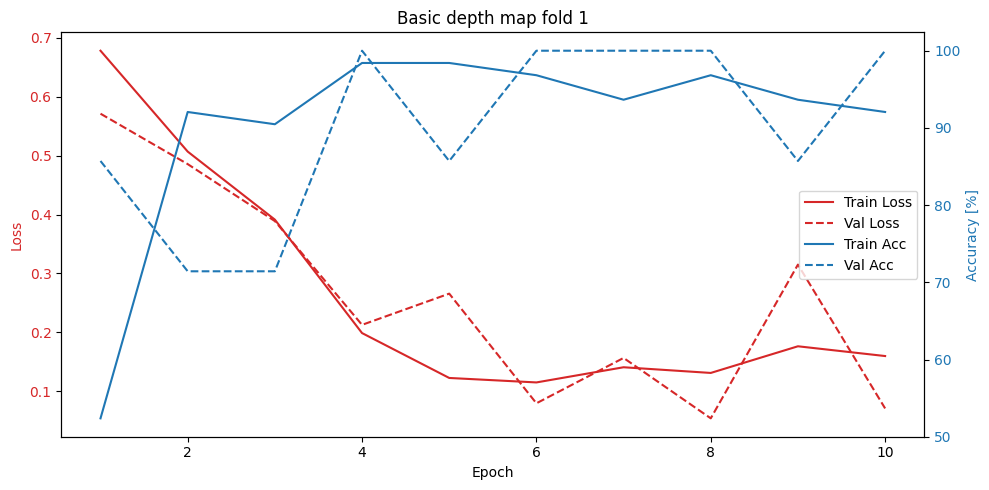


========== FOLD 2/10 ==========
Epoch [1/10] TRAIN Loss: 0.5904 Acc: 66.67% | VAL Loss: 0.4608 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4066 Acc: 96.83% | VAL Loss: 0.3378 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2276 Acc: 98.41% | VAL Loss: 0.2459 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2599 Acc: 93.65% | VAL Loss: 0.6032 Acc: 57.14% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2225 Acc: 92.06% | VAL Loss: 0.1188 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1192 Acc: 96.83% | VAL Loss: 0.1945 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1558 Acc: 95.24% | VAL Loss: 0.6811 Acc: 57.14% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.2514 Acc: 90.48% | VAL Loss: 0.3053 Acc: 85.71% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.2124 Acc: 93.65% | VAL Loss: 0.1727 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.2311 Acc: 85.71% | VAL Loss: 0.0852 Acc: 100.00% | LR: 5.00e-05


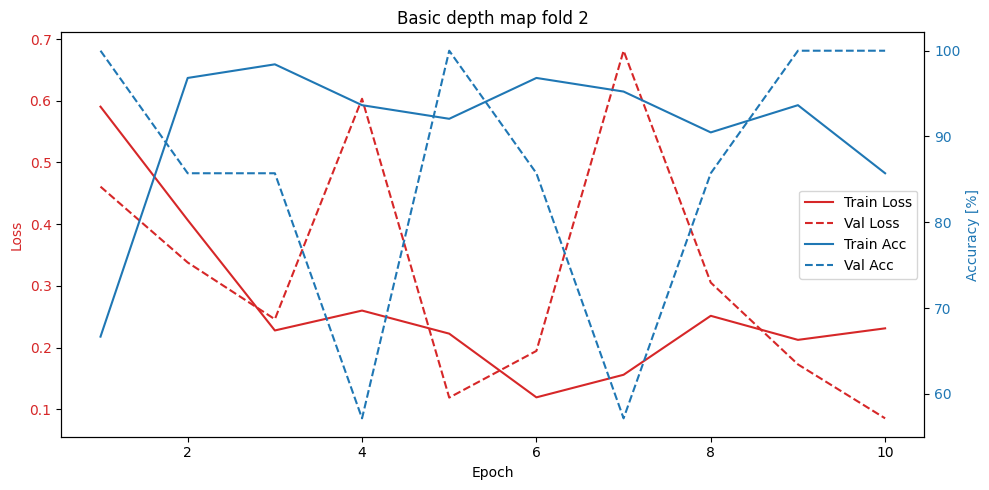


========== FOLD 3/10 ==========
Epoch [1/10] TRAIN Loss: 0.6511 Acc: 63.49% | VAL Loss: 0.5873 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4840 Acc: 88.89% | VAL Loss: 0.4964 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3091 Acc: 92.06% | VAL Loss: 0.2952 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3315 Acc: 90.48% | VAL Loss: 0.1690 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1745 Acc: 98.41% | VAL Loss: 0.2248 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2988 Acc: 85.71% | VAL Loss: 0.5208 Acc: 57.14% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2233 Acc: 92.06% | VAL Loss: 0.4325 Acc: 57.14% | LR: 5.00e-05
Epoch [8/10] TRAIN Loss: 0.3045 Acc: 87.30% | VAL Loss: 0.1924 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1793 Acc: 95.24% | VAL Loss: 0.0992 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1353 Acc: 96.83% | VAL Loss: 0.3000 Acc: 85.71% | LR: 5.00e-05


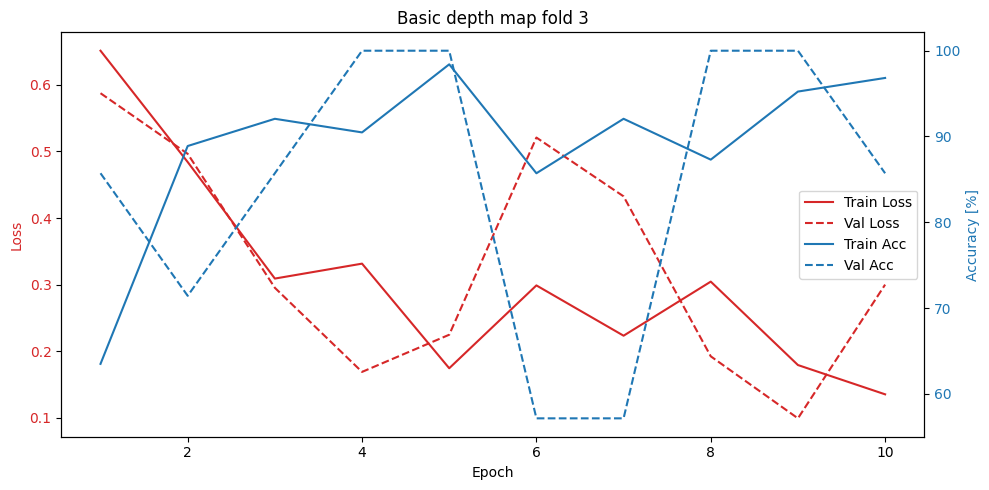


========== FOLD 4/10 ==========
Epoch [1/10] TRAIN Loss: 0.5788 Acc: 80.95% | VAL Loss: 0.4732 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4480 Acc: 92.06% | VAL Loss: 0.3346 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3352 Acc: 87.30% | VAL Loss: 0.2430 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1901 Acc: 96.83% | VAL Loss: 0.1353 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.0738 Acc: 100.00% | VAL Loss: 0.2209 Acc: 85.71% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1235 Acc: 95.24% | VAL Loss: 0.0537 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0247 Acc: 100.00% | VAL Loss: 0.1362 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0268 Acc: 100.00% | VAL Loss: 0.0433 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.2540 Acc: 88.89% | VAL Loss: 0.0274 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1727 Acc: 92.06% | VAL Loss: 0.0575 Acc: 100.00% | LR: 1.00e-04


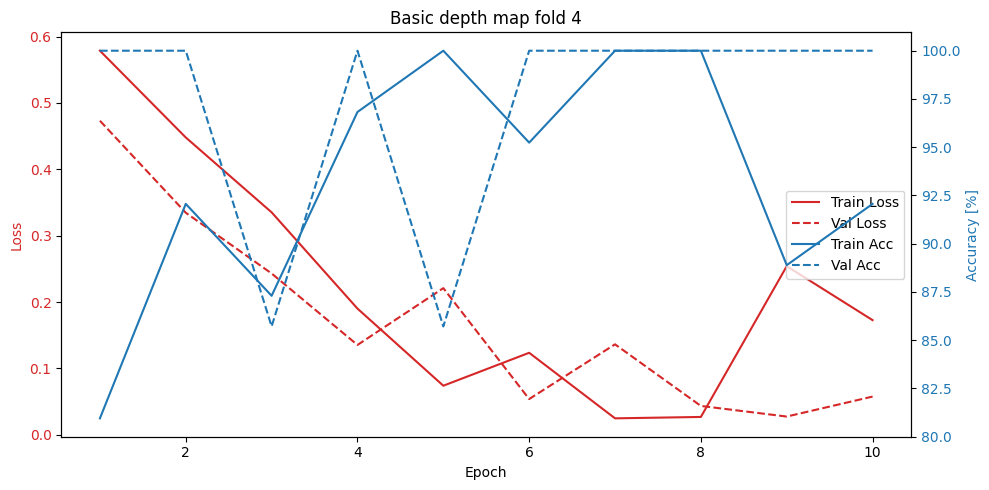


========== FOLD 5/10 ==========
Epoch [1/10] TRAIN Loss: 0.6244 Acc: 74.60% | VAL Loss: 0.6009 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5020 Acc: 80.95% | VAL Loss: 0.4741 Acc: 57.14% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3857 Acc: 90.48% | VAL Loss: 0.3147 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2679 Acc: 92.06% | VAL Loss: 0.2144 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1656 Acc: 93.65% | VAL Loss: 0.1859 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1270 Acc: 96.83% | VAL Loss: 0.1485 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2186 Acc: 90.48% | VAL Loss: 0.1129 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1242 Acc: 96.83% | VAL Loss: 0.0933 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.2632 Acc: 90.48% | VAL Loss: 0.4827 Acc: 57.14% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1832 Acc: 90.48% | VAL Loss: 0.5154 Acc: 57.14% | LR: 1.00e-04


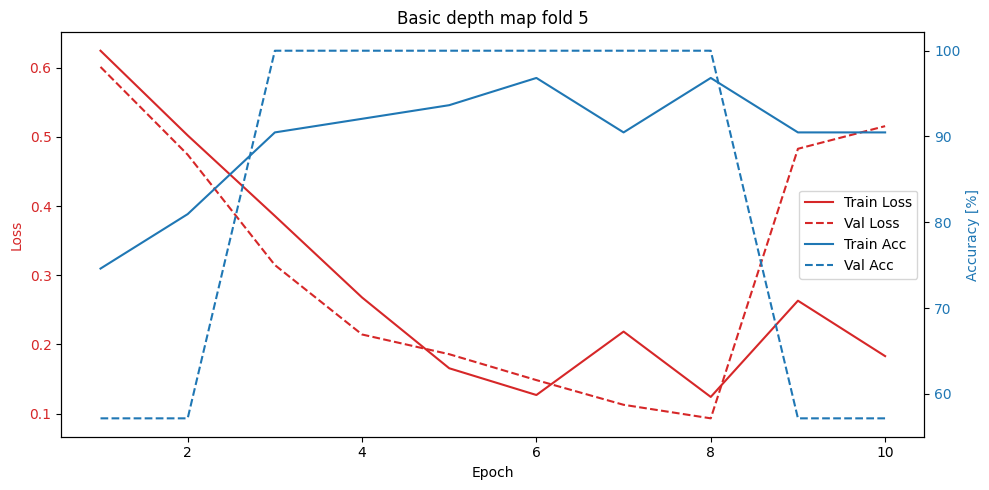


========== FOLD 6/10 ==========
Epoch [1/10] TRAIN Loss: 0.7172 Acc: 52.38% | VAL Loss: 0.6030 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5420 Acc: 68.25% | VAL Loss: 0.4721 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4550 Acc: 84.13% | VAL Loss: 0.4560 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3192 Acc: 93.65% | VAL Loss: 0.4893 Acc: 57.14% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2552 Acc: 93.65% | VAL Loss: 0.1987 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1980 Acc: 95.24% | VAL Loss: 0.1186 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1387 Acc: 96.83% | VAL Loss: 0.1797 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1303 Acc: 93.65% | VAL Loss: 0.2284 Acc: 85.71% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1048 Acc: 98.41% | VAL Loss: 0.1488 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.2009 Acc: 93.65% | VAL Loss: 0.0737 Acc: 100.00% | LR: 5.00e-05


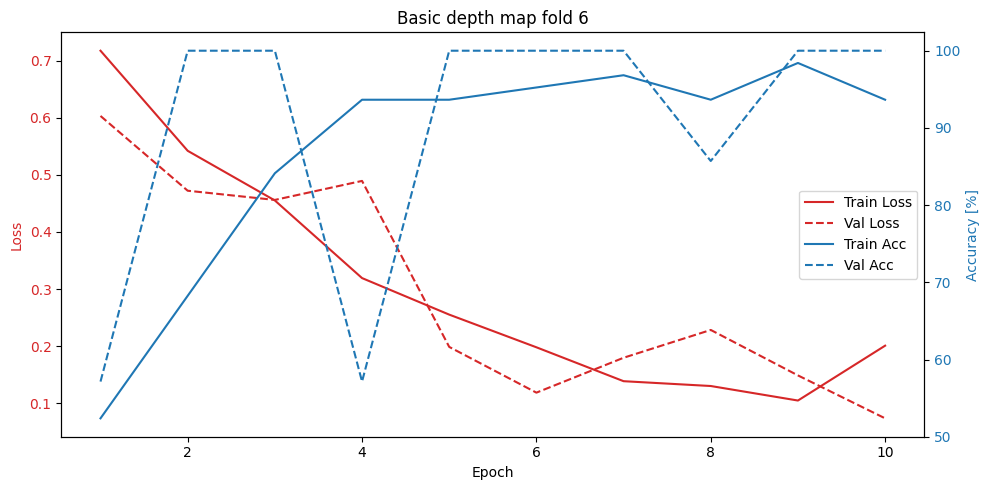


========== FOLD 7/10 ==========
Epoch [1/10] TRAIN Loss: 0.5996 Acc: 80.95% | VAL Loss: 0.5816 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4561 Acc: 90.48% | VAL Loss: 0.4881 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2838 Acc: 93.65% | VAL Loss: 0.2753 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1405 Acc: 100.00% | VAL Loss: 0.2864 Acc: 85.71% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2871 Acc: 87.30% | VAL Loss: 0.1539 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.4827 Acc: 82.54% | VAL Loss: 0.2608 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2520 Acc: 87.30% | VAL Loss: 0.1906 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.2286 Acc: 90.48% | VAL Loss: 0.2010 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.2001 Acc: 95.24% | VAL Loss: 0.2006 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1452 Acc: 95.24% | VAL Loss: 0.8001 Acc: 57.14% | LR: 5.00e-05


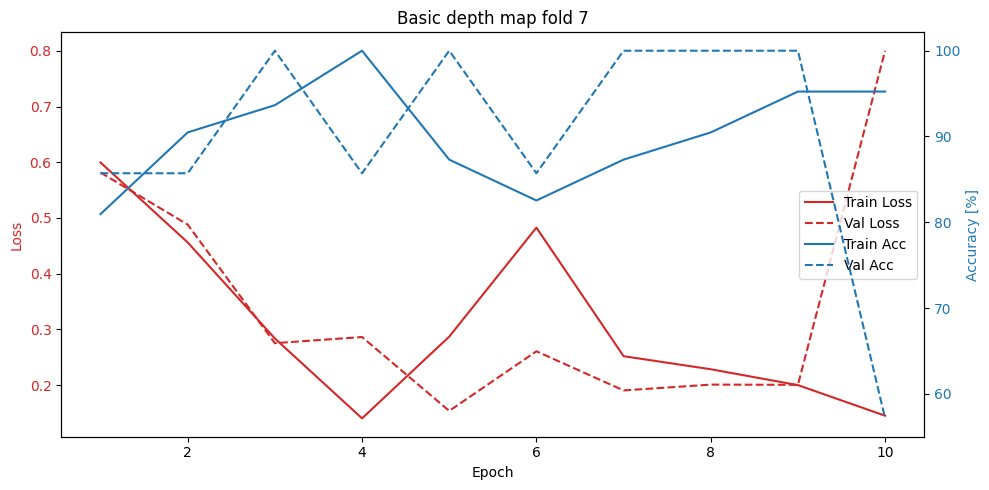


========== FOLD 8/10 ==========
Epoch [1/10] TRAIN Loss: 0.6582 Acc: 66.67% | VAL Loss: 0.5579 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5104 Acc: 82.54% | VAL Loss: 0.5195 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4273 Acc: 87.30% | VAL Loss: 0.4425 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2289 Acc: 93.65% | VAL Loss: 0.2792 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1093 Acc: 100.00% | VAL Loss: 0.2041 Acc: 85.71% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2131 Acc: 88.89% | VAL Loss: 0.1812 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1005 Acc: 100.00% | VAL Loss: 0.1386 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0246 Acc: 100.00% | VAL Loss: 0.1416 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.0258 Acc: 100.00% | VAL Loss: 0.0723 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0261 Acc: 100.00% | VAL Loss: 0.1195 Acc: 100.00% | LR: 1.00e-04


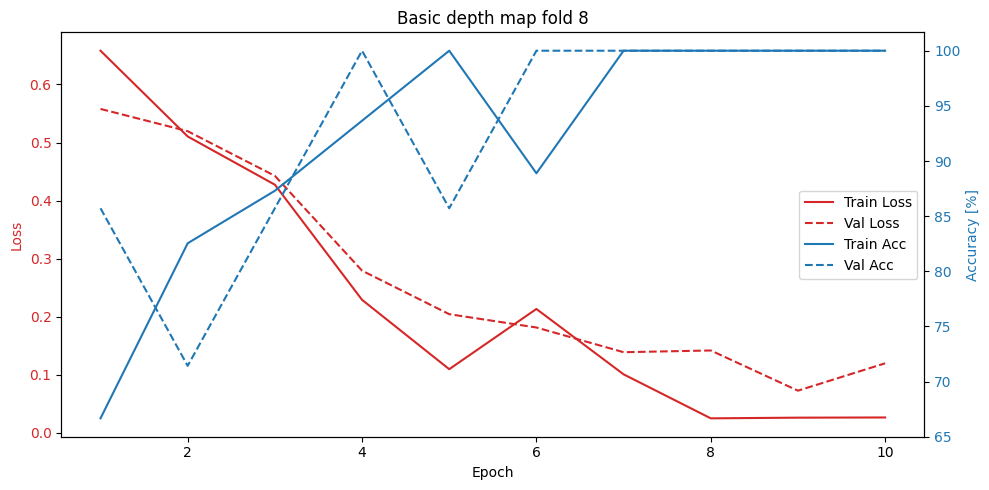


========== FOLD 9/10 ==========
Epoch [1/10] TRAIN Loss: 0.6582 Acc: 52.38% | VAL Loss: 0.5447 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4642 Acc: 90.48% | VAL Loss: 0.3962 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3874 Acc: 87.30% | VAL Loss: 0.2987 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3975 Acc: 84.13% | VAL Loss: 0.3714 Acc: 71.43% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2593 Acc: 90.48% | VAL Loss: 0.1454 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1170 Acc: 100.00% | VAL Loss: 0.1445 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1160 Acc: 96.83% | VAL Loss: 0.1077 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0964 Acc: 96.83% | VAL Loss: 0.0398 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1244 Acc: 96.83% | VAL Loss: 0.0800 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1829 Acc: 88.89% | VAL Loss: 0.1929 Acc: 100.00% | LR: 1.00e-04


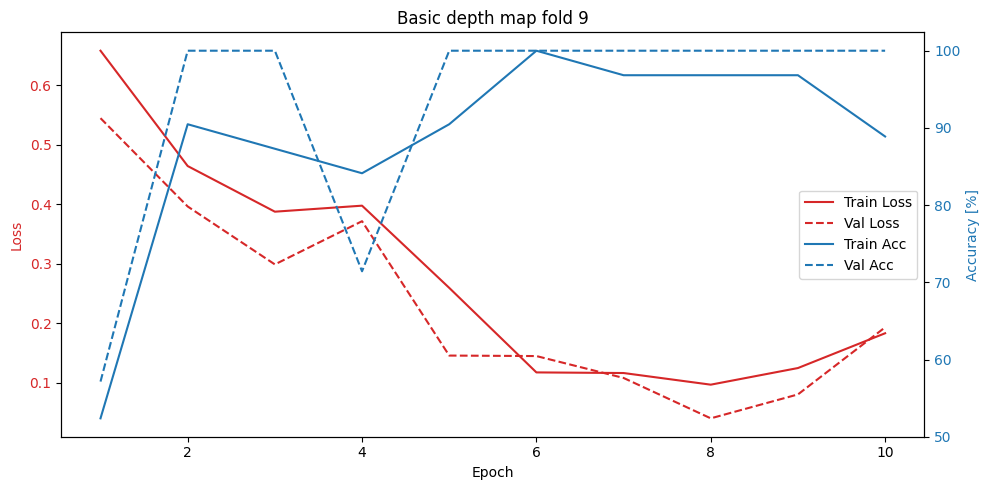


========== FOLD 10/10 ==========
Epoch [1/10] TRAIN Loss: 0.6472 Acc: 61.90% | VAL Loss: 0.5657 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4957 Acc: 88.89% | VAL Loss: 0.4616 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3577 Acc: 92.06% | VAL Loss: 0.3047 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2258 Acc: 93.65% | VAL Loss: 0.2291 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1207 Acc: 98.41% | VAL Loss: 0.1534 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2625 Acc: 90.48% | VAL Loss: 0.1682 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2446 Acc: 87.30% | VAL Loss: 0.1582 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1559 Acc: 92.06% | VAL Loss: 0.1700 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1146 Acc: 95.24% | VAL Loss: 0.1405 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.0929 Acc: 96.83% | VAL Loss: 0.0860 Acc: 100.00% | LR: 5.00e-05


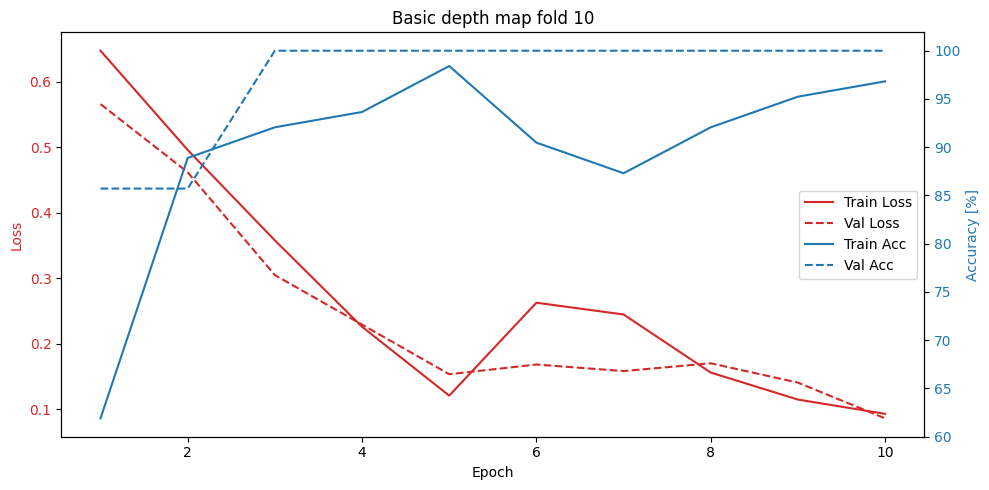

In [9]:
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f'\n========== FOLD {fold+1}/{num_folds} ==========')

    model = CNN_LSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=True
    )

    best_val_loss = 1e10
    best_model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # ===================== TRAIN =====================
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for videos, y in train_loader:
            videos = videos.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * videos.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss /= len(train_dataset)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ===================== VAL =====================
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for videos, y in val_loader:
                videos = videos.to(device)
                y = y.to(device)

                outputs = model(videos)
                loss = criterion(outputs, y)

                val_loss += loss.item() * videos.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        
        val_loss /= len(val_dataset)
        val_acc = 100 * correct / total

        scheduler.step(val_loss)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        print(
            f'Epoch [{epoch+1}/{num_epochs}] '
            f'TRAIN Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
            f'VAL Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | '
            f'LR: {current_lr:.2e}'
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    # ===================== PLOT =====================
    epochs = range(1, num_epochs + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, label='Train Loss', color='tab:red')
    ax1.plot(epochs, val_losses, label='Val Loss', color='tab:red', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy [%]', color='tab:blue')
    ax2.plot(epochs, train_accs, label='Train Acc', color='tab:blue')
    ax2.plot(epochs, val_accs, label='Val Acc', color='tab:blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    plt.title(f'Basic depth map fold {fold+1}')
    plt.tight_layout()
    plt.show()


========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========

Fold 1:
{'fold': 0, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 2:
{'fold': 1, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 3:
{'fold': 2, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 4:
{'fold': 3, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 5:
{'fold': 4, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 6:
{'fold': 5, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 7:
Errors:
adl/sequence-05


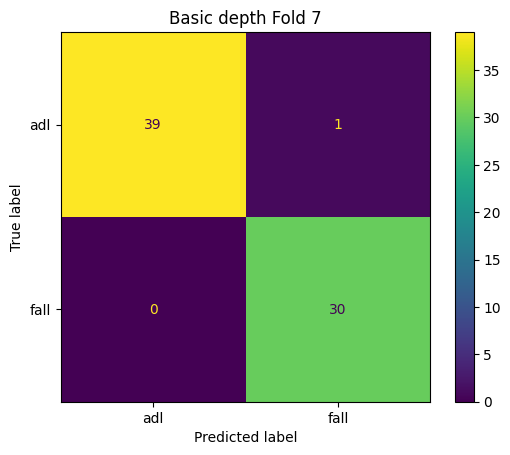

{'fold': 6, 'acc': 0.9857142857142858, 'prec': 0.967741935483871, 'rec': 1.0, 'f1': 0.9836065573770492}

Fold 8:
{'fold': 7, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 9:
{'fold': 8, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 10:
{'fold': 9, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}


In [9]:
print('\n========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========')

final_results = []

full_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    generator=g
)

for fold in range(num_folds):
    model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'
    print(f'\nFold {fold+1}:')

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        error_fragments = []
        for batch_idx, (videos, y) in enumerate(full_loader):
            videos = videos.to(device)
            y = y.to(device)

            outputs = model(videos)
            _, preds = torch.max(outputs, 1)

            incorrect_idx = (preds != y).nonzero(as_tuple=True)[0]

            start_idx = batch_idx * full_loader.batch_size
            global_incorrect_idx = start_idx + incorrect_idx

            for idx in global_incorrect_idx:
                full_path = full_loader.dataset.samples[idx.item()][0]
                full_path_str = str(full_path)
                parts = full_path_str.split('/')[-3:-1]
                fragment = '/'.join(parts)
                error_fragments.append(fragment)


            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    if error_fragments:
        print("Errors:")
        for f in error_fragments:
            print(f)
        
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=['adl', 'fall']
        )

        disp.plot()
        plt.title(f'Basic depth Fold {fold+1}')
        plt.show()

    metrics = {
        'fold': fold,
        'acc': accuracy_score(all_labels, all_preds),
        'prec': precision_score(all_labels, all_preds, average='binary'),
        'rec': recall_score(all_labels, all_preds, average='binary'),
        'f1': f1_score(all_labels, all_preds, average='binary'),
    }

    final_results.append(metrics)
    print(metrics)


In [10]:
print('\n========== CV RESULTS ==========')

for metric in final_results[0].keys():
    if metric == 'fold':
        continue
    values = [f[metric] for f in final_results]
    print(
        f'{metric.upper()}: '
        f'{np.mean(values)*100:.2f}% std: {np.std(values)*100:.2f}%'
    )



========== CV RESULTS ==========
ACC: 99.86% std: 0.43%
PREC: 99.68% std: 0.97%
REC: 100.00% std: 0.00%
F1: 99.84% std: 0.49%
